In [67]:
# Numerical analysis
import numpy as np
import jax.lax as lax
import jax.numpy as jnp
from jax import random
from jax.nn import sigmoid

# Bayesian inference
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import arviz as az

# Dataframes
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Set pseudo random number key
prng_key = random.PRNGKey(0)

# MODEL CONSTANTS
n_realizations = 5

# MCMC PARAMETERS
num_warmup = 500
num_samples = 1000
num_chains = 4

# TESTING
lams = [1, 1/10, 1/500, 1/10000]
sigma = 0.1
p = 1/2

/Users/graceliu/miniconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/Users/graceliu/miniconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/Users/graceliu/miniconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/Users/graceliu/miniconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/Users/graceliu/miniconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:1615: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)
/Users/graceliu/miniconda3/lib/python3.12/site-pac

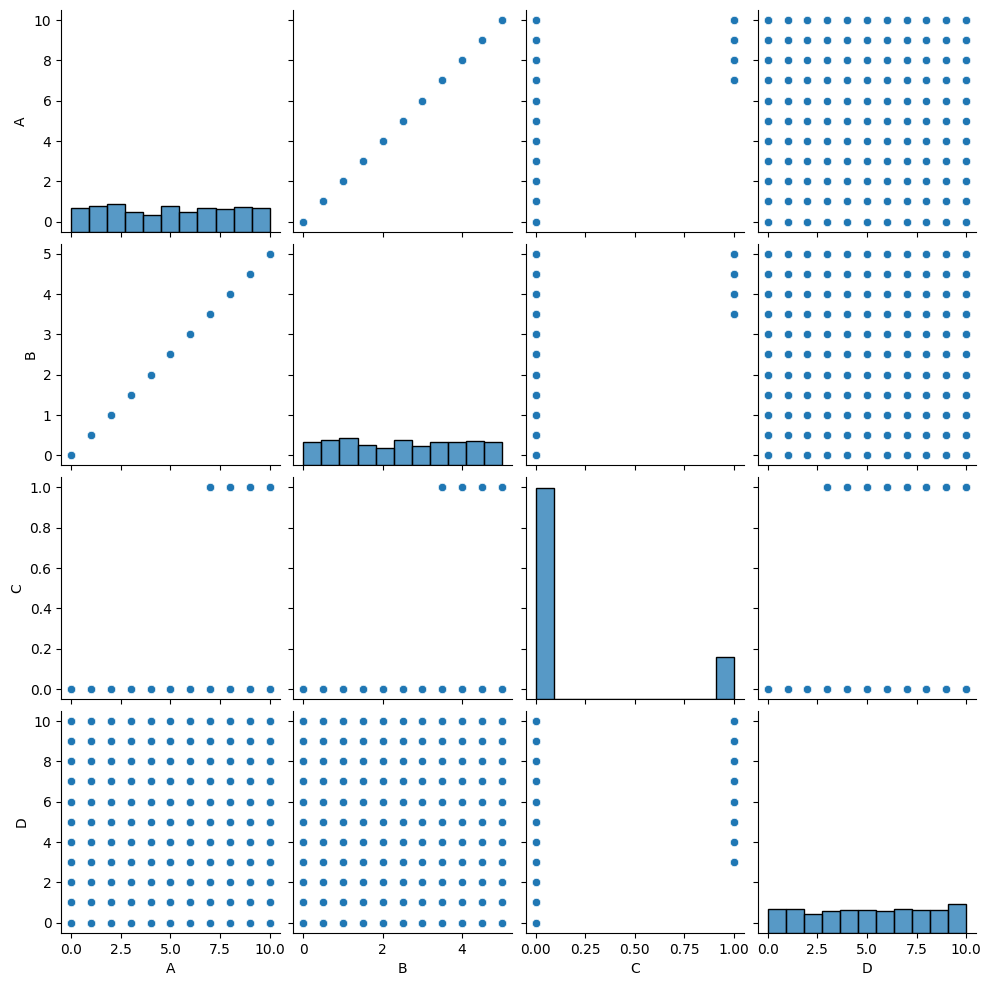

In [68]:
# Load data file
dset = pd.read_csv("data/abcd_dag.csv", sep=",")

def standardize(x):
    return (x-x.mean(0)) / x.std(0)

y = dset["D"].values
X = dset[["A", "B", "C"]].values


vars = [
    "A",
    "B",
    "C",
    "D"
]
sns.pairplot(dset, x_vars=vars, y_vars=vars, palette="husl")
plt.show()

X = standardize(X)
y = standardize(y)

<h2> Defining the Model </h2>

In [69]:
def model(alphas, lam, X, y=None):
    '''
    Defines the Concrete random variable distribution.

    Parameters:
       real lam: temperature coefficient
       array alphas: parameter, Dx1
       array X: input data, NxD
       array y: output data, Nx1
    '''
    D = X.shape[1]
    U = numpyro.sample("U", dist.Uniform(0, 1).expand([D]))
    L = numpyro.deterministic("L", jnp.log(U) - jnp.log(1-U))
    T = numpyro.deterministic("T", jnp.log(alphas) - jnp.log(1-alphas))
    z_lam = numpyro.deterministic("z_lam", ((lam**2+lam+1)/(lam+1)) * T + L)

    gammas = numpyro.deterministic("gammas", sigmoid(z_lam/lam))
    y_mean = jnp.dot(X, gammas) #Nx1
    y = numpyro.sample("y", dist.Bernoulli(y_mean), obs=y) 

In [70]:
def run_mcmc(model, prng_key, **kwargs):
    '''
    Run MCMC using the given model.

    Parameters:
       model: probabilistic model
       prng_key: random key 
       array y: observed data

    '''
    nuts = NUTS(model)
    mcmc = MCMC(nuts, num_warmup=num_warmup, num_samples=num_samples, num_chains=2, progress_bar=True)
    mcmc.run(prng_key, **kwargs)
    return mcmc

In [71]:
def concrete(X, y, lam):
    '''
    Parameters:
       dict all_data: keys are integers and values are the corresponding tuple (X, Y)
       int lam: temperature coefficient
    
    Returns:
       arr mean_gammas: size (D,)
       dict samples: keys are sampled values in the mcmc model, values are the samples
       mcmc: a Numpyro MCMC object

    '''
    k = (lam**2+lam+1) / (lam+1)
    numerator = (p/(1-p))**(1/k)
    denominator = 1 + (p/(1-p))**(1/k)
    alphas = jnp.zeros(X.shape[1])
    alphas += (numerator / denominator)
    mcmc = run_mcmc(model, prng_key, alphas = alphas, lam = lam, X=X, y=y)
    samples = mcmc.get_samples()
    mean_gammas =  samples["gammas"]
   #  plt.figure(figsize=(12, 6))
   #  plt.subplot(1, 2, 1)
   #  sns.histplot(mean_gammas, kde=True)
   #  plt.title('Distribution of Mean Gammas')
   #  plt.tight_layout()
   #  plt.show()
    return mean_gammas, samples, mcmc

<h1> Run and Evaluate MCMC </h1>

In [72]:
all_mses = dict()
mean_mses = dict()
mean_betas = dict()
mean_gammas = dict()
all_mcmc_runs = []
all_data = {}

for _ in range(n_realizations):
    for lam in lams:
        gammas, all_samples, mcmc = concrete(X, y, lam=lam)
        if lam not in mean_gammas:
            mean_gammas[lam] = []
        mean_gammas[lam].append(gammas)
        all_mcmc_runs.append(mcmc)

/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_62395/2872204839.py:12: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup=num_warmup, num_samples=num_samples, num_chains=2, progress_bar=True)
sample: 100%|██████████| 1500/1500 [00:00<00:00, 7430.26it/s, 7 steps of size 4.44e-01. acc. prob=0.78]
/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_62395/2872204839.py:12: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are availabl

The <a href=https://mc-stan.org/docs/2_21/reference-manual/effective-sample-size-section.html>estimated effective sample size (ESS)</a> measures how much information is lost in MCMC due to correlation between different samples.

The <a href=https://arxiv.org/abs/1812.09384>Gelman-Rubin statistic</a> ($\hat{R}$) examines how well the chains have mixed. Common thresholds used include $1.01$, $1.05$, and $1.1$.

In [73]:
for mcmc in all_mcmc_runs:
    mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      U[0]      0.02      0.02      0.02      0.00      0.05    354.35      1.01
      U[1]      0.02      0.02      0.02      0.00      0.04    380.02      1.01
      U[2]      0.31      0.02      0.31      0.28      0.35    261.43      1.01

Number of divergences: 930

                mean       std    median      5.0%     95.0%     n_eff     r_hat
      U[0]      0.21      0.12      0.21      0.00      0.37    163.65      1.01
      U[1]      0.20      0.12      0.20      0.00      0.37    289.96      1.02
      U[2]      0.48      0.00      0.48      0.48      0.49    301.19      1.00

Number of divergences: 410

                mean       std    median      5.0%     95.0%     n_eff     r_hat
      U[0]      0.25      0.14      0.25      0.00      0.45    163.38      1.02
      U[1]      0.26      0.15      0.27      0.00      0.46     99.44      1.02
      U[2]      0.50      0.00      0.50      0.50

<h1> Results </h1>

1 [0.02075396 0.01992066 0.31204665]
0.1 [0.00184877 0.0018287  0.33564788]
0.002 [2.6654559e-05 2.7243052e-05 3.3636844e-01]
0.0001 [1.7238060e-09 5.8205222e-24 1.0000000e+00]


(-0.05, 1.05)

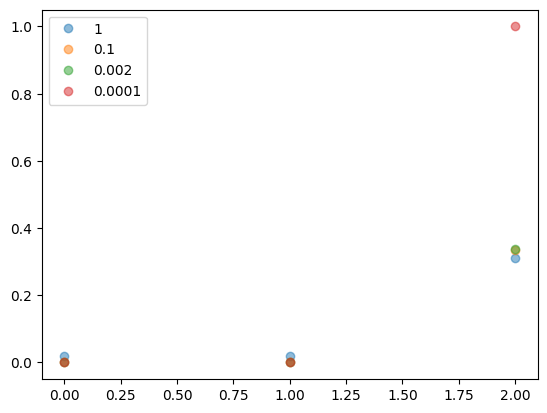

In [74]:
for lam in lams: 
    # for x in mean_gammas[lam]:
    #     plt.plot(x, '.', label=lam)
    #     # print(lam, mean_gammas[lam])
    plt.plot(np.array(mean_gammas[lam]).mean(0).mean(0), 'o', label=lam, alpha=0.5)
    print(lam, np.array(mean_gammas[lam]).mean(0).mean(0))

plt.legend()
plt.ylim(-0.05, 1.05)

In [75]:
y = dict()
for i in range(3):
    y[i] = dict()

for lam in lams:
    mean_gammas[lam] = np.array(mean_gammas[lam])
    for i in range(3):
        y[i][lam] = np.ndarray.flatten(mean_gammas[lam][:, :, i])

/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_62395/3163191656.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(y[2][lam], ax=axs[1, 0])


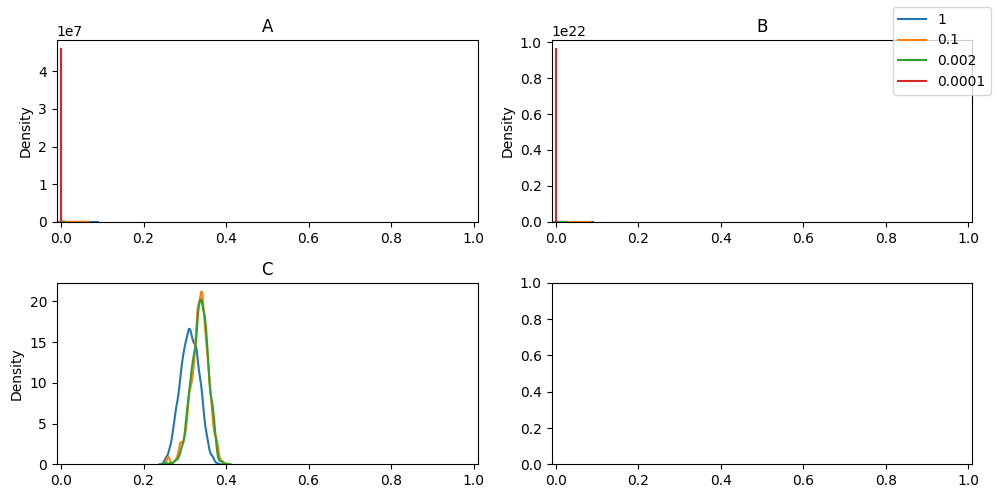

In [76]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(10, 5)

for lam in lams:
    sns.kdeplot(y[0][lam], ax=axs[0, 0], label=f'{lam}')
    sns.kdeplot(y[1][lam], ax=axs[0, 1])
    sns.kdeplot(y[2][lam], ax=axs[1, 0])

for ax in axs.flat:
    ax.set_xlim(-0.01, 1.01)

axs[0, 0].set_title("A")
axs[0, 1].set_title("B")
axs[1, 0].set_title("C")

plt.tight_layout()
fig.legend()

In [77]:
# samples_1 = mcmc.get_samples()
# predictive = Predictive(model, samples_1)
# predictions = predictive(random.PRNGKey(1),
#                          alphas = jnp.ones(X.shape[1]),
#                          lam=10000, 
#                          X=X,
#                          y=y)['y']
# mean_pred = predictions.mean(0)

# plt.plot(mean_pred, '.')
# plt.plot(y, '.')

# print(sum((mean_pred - y)**2))